# Build the LegacyHalos Parent Sample

The goal of this notebook is to build a parent sample of galaxies as part of a pilot analysis of the central galaxies in massive dark matter halos identified in Legacy Survey imaging.  The output parent sample is required (1) to be in the redMaPPer cluster catalog and (2) have full-depth Legacy Survey *grzW1W2* imaging as part of the fifth data release (DR5).  A second (smaller) parent sample will also overlap with the *UPenn-PhotDec* photometric catalog.

The input (row-matched) catalogs are:
* \$REDMAPPER_DIR/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit
* \$REDMAPPER_DIR/v6.3.1/redmapper-v6.3.1-lgt5-sdssWISEphot.fits (generated by [redmapper-casjobs.ipynb](https://github.com/moustakas/legacyhalos/tree/master/nb/redmapper-casjobs.ipynb))
* \$REDMAPPER_DIR/v6.3.1/legacysurvey-dr5-redmapper-v6.3.1.fits (generated by [match-legacysurvey-redmapper.ipynb](https://github.com/moustakas/legacyhalos/tree/master/nb/match-legacysurvey-redmapper.ipynb))

The output (row-matched) catalogs are stored in the following multi-extension FITS file for the full parent sample:
* \$LEGACYHALOS_DIR/legacyhalos-parent.fits
  * [SDSSPHOT] - Coordinates and SDSS/unWISE photometry
  * [REDMAPPER] - redMaPPer cluster properties (e.g., richness)
  * [LSPHOT] - LegacySurvey photometry

and in the following multi-extension FITS file for the subset of objects that also match the UPenn-PhotDec catalog:
* \$LEGACYHALOS_DIR/legacyhalos-upenn-parent.fits
  * [SDSSPHOT] - Coordinates and SDSS/unWISE photometry
  * [REDMAPPER] - redMaPPer cluster properties (e.g., richness)
  * [LSPHOT] - LegacySurvey photometry
  * [UPENN] - UPenn-Photdec photometry and bulge/disk decomposition properties

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import fitsio
from astropy.io import fits
from astropy.table import Table, hstack
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
plt.style.use('seaborn-talk')
%matplotlib inline

### Specify the LegacyHalos path and output files names.

In [3]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')
parentfile = os.path.join(legacyhalos_dir, 'legacyhalos-parent.fits')
parentupennfile = os.path.join(legacyhalos_dir, 'legacyhalos-upenn-parent.fits')

### Read the matched Legacy Survey and redMaPPer catalogs.

In [4]:
def convert_legacysurvey_datamodel(indata):
    """Convenience routine to convert from the (~obsolete) DR3 data model to 
    the (latest) DR4 data model.  
    
    This code was adapted from desitarget.io.convert_from_old_data_model
    and was originally written by Adam Myers (Wyoming).
    
    """
    from astropy.table import Table, Column
    
    nrows = len(indata)
    outdata = indata.copy()
    
    # Change the DECAM columns from the old (2-D array) to new (named 1-D array) data model.
    decamcols = ['FLUX', 'FLUX_IVAR', 'MW_TRANSMISSION', 'FRACFLUX', 'NOBS', 'GALDEPTH']
    decambands = 'UGRIZY'
    for colstring in decamcols:
        for bandnum in [1, 2, 4]:
            outdata.add_column(Column(name=colstring+'_'+decambands[bandnum], 
                                      data=indata['DECAM_'+colstring][:, bandnum]))
        outdata.remove_column('DECAM_'+colstring)
        
    # Treat DECAM_DEPTH separately as the syntax is slightly different.
    for bandnum in [1, 2, 4]:
        outdata.add_column(Column(name='PSFDEPTH_'+decambands[bandnum], 
                                  data=indata['DECAM_DEPTH'][:, bandnum]))
    outdata.remove_column('DECAM_DEPTH')

    # Change the WISE columns from the old (2-D array) to new (named 1-D array) data model.
    wisecols = ['FLUX', 'FLUX_IVAR', 'MW_TRANSMISSION']
    for colstring in wisecols:
        for bandnum in [1, 2, 3, 4]:
            outdata.add_column(Column(name=colstring+'_W'+str(bandnum),
                                      data=indata['WISE_'+colstring][:, bandnum-1]))
        outdata.remove_column('WISE_'+colstring)

    # Also include the RELEASE, which we'll always assume is DR3.
    outdata['RELEASE'] = 3000
    
    return outdata

In [5]:
def read_legacysurvey(dr='dr5', rmversion='v6.3.1'):
    """Read the matched Legacy Survey catalog converted to the >=DR4
    data model.
    
    Note that non-matching entries are populated with zeros / False.
    
    """
    lsfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                           'legacysurvey-{}-redmapper-{}-lgt5.fits'.format(dr, rmversion) )
    ls = Table(fits.getdata(lsfile, ext=1, upper=True))
    
    print('Read {} objects from {}'.format(len(ls), lsfile))

    if dr == 'dr3':
        return convert_legacysurvey_datamodel(ls)
    else:
        return ls

In [6]:
def read_redmapper_photometry(rmversion='v6.3.1', index=None):
    """Read the redMaPPer photometric catalog.
    
    """
    rmphotfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'redmapper-{}-lgt5-sdssWISEphot.fits'.format(rmversion) )
    if index is not None:
        rmphot = Table(fits.getdata(rmphotfile, ext=1, upper=True, rows=index))
    else:
        rmphot = Table(fits.getdata(rmphotfile, ext=1, upper=True))
    print('Read {} objects from {}'.format(len(rmphot), rmphotfile))

    return rmphot

In [7]:
def read_redmapper(rmversion='v6.3.1', index=None):
    """Read the parent redMaPPer catalog.
    
    """
    rmfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'dr8_run_redmapper_{}_lgt5_catalog.fit'.format(rmversion) )
    if index is not None:
        rm = Table(fits.getdata(rmfile, ext=1, upper=True, rows=index))
    else:
        rm = Table(fits.getdata(rmfile, ext=1, upper=True))
    print('Read {} objects from {}'.format(len(rm), rmfile))

    return rm

#### Require a match with redMaPPer and non-zero depth in all three bands.

In [8]:
dr, rmversion = 'dr5', 'v6.3.1'
lsall = read_legacysurvey(dr=dr, rmversion=rmversion)

Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr5-redmapper-v6.3.1-lgt5.fits


In [9]:
lsmatched = np.where( 
    (lsall['BRICK_PRIMARY']) * 
    (lsall['GALDEPTH_G'] > 0) * 
    (lsall['GALDEPTH_R'] > 0) * 
    (lsall['GALDEPTH_Z'] > 0) )[0]
print('Identified {} objects with grz photometry and a match to redMaPPer.'.format(len(lsmatched)))
ls = lsall[lsmatched]
ls

Identified 187330 objects with grz photometry and a match to redMaPPer.


RELEASE,BRICKID,BRICKNAME,OBJID,BRICK_PRIMARY,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,BX,BY,DCHISQ [5],EBV,MJD_MIN,MJD_MAX,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,APFLUX_U [8],APFLUX_G [8],APFLUX_R [8],APFLUX_I [8],APFLUX_Z [8],APFLUX_Y [8],APFLUX_RESID_U [8],APFLUX_RESID_G [8],APFLUX_RESID_R [8],APFLUX_RESID_I [8],APFLUX_RESID_Z [8],APFLUX_RESID_Y [8],APFLUX_IVAR_U [8],APFLUX_IVAR_G [8],APFLUX_IVAR_R [8],APFLUX_IVAR_I [8],APFLUX_IVAR_Z [8],APFLUX_IVAR_Y [8],MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,LC_FLUX_W1 [7],LC_FLUX_W2 [7],LC_FLUX_IVAR_W1 [7],LC_FLUX_IVAR_W2 [7],LC_NOBS_W1 [7],LC_NOBS_W2 [7],LC_FRACFLUX_W1 [7],LC_FRACFLUX_W2 [7],LC_RCHISQ_W1 [7],LC_RCHISQ_W2 [7],LC_MJD_W1 [7],LC_MJD_W2 [7],FRACDEV,FRACDEV_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR
int16,int32,str8,int32,bool,str4,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str8,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
5000,323959,1978m012,707,True,EXP,197.872891379,-1.34106771596,6.07515e+12,4.53595e+12,1828.47,548.187,739573.0 .. 2.09297e+06,0.0271215,56385.2985828,57814.2954173,0.0,46.2151,144.898,0.0,291.876,0.0,305.293,220.864,40.3282,300.882,0.0,80.2267,52.6743,0.0,9.57023,0.0,0.814653,0.17559,0.000649695,1.56438e-05,0.0 .. 0.0,1.98649 .. 89.4603,6.19044 .. 270.822,0.0 .. 0.0,13.9039 .. 548.453,0.0 .. 0.0,0.0 .. 0.0,-0.160506 .. -0.916563,-0.433822 .. -4.53955,0.0 .. 0.0,-0.973791 .. -25.4664,0.0 .. 0.0,0.0 .. 0.0,8957.3 .. 42.8288,6370.25 .. 31.9015,0.0 .. 0.0,811.878 .. 3.88175,0.0 .. 0.0,0.905023,0.922853,0.947355,0.961012,0.970202,0.973772,0.995414,0.997181,0.999398,0.999773,0,3,8,0,5,0,62,60,12,12,0.0,2.20121,3.22142,0.0,5.6462,0.0,30.1427,4.91518,0.598611,0.0794355,0.0,0.309822,0.310862,0.0,0.

In [10]:
rmphotall = read_redmapper_photometry(rmversion=rmversion)
assert(len(rmphotall) == len(lsall))

Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/redmapper-v6.3.1-lgt5-sdssWISEphot.fits


In [11]:
rmphot = rmphotall[lsmatched]
rmphot

MEM_MATCH_ID,OBJID,RUN,RERUN,CAMCOL,FIELD,RA,DEC,PETROMAGGIES [5],PETROMAGGIES_IVAR [5],MODELMAGGIES [5],MODELMAGGIES_IVAR [5],CMODELMAGGIES [5],CMODELMAGGIES_IVAR [5],WISE_NANOMAGGIES [2],WISE_NANOMAGGIES_IVAR [2],EXTINCTION [5],PETROR50 [5]
int32,int64,int64,int64,int64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
3,1237655500272500810,2334,301,6,13,197.872956459,-1.3411176982,-19.8656 .. 108.208,0.00854354 .. 4.0306e-05,5.86714 .. 920.437,0.139 .. 0.00699053,1.85612 .. 464.897,1.89186 .. 0.026475,12584.4 .. 14754.4,0.000359241 .. 3.38049e-05,0.114984 .. 0.0342593,-9999.0 .. 1.21615
4,1237664852576633380,4512,301,2,209,230.600086411,27.7143712172,53.7736 .. 1718.61,0.0553758 .. 0.00150141,65.9349 .. 2106.42,0.436373 .. 0.0138082,57.1911 .. 1808.63,0.413412 .. 0.0188815,24571.6 .. 25315.6,0.00175937 .. 0.000159679,0.168863 .. 0.0503123,4.16933 .. 4.07635
7,1237678602382344780,7713,301,5,282,8.03426642874,18.1070248394,8.04202 .. 48.6239,0.196601 .. 0.0139645,1.35466 .. 84.9651,2.34027 .. 0.106668,28.9637 .. 64.3609,0.0334751 .. 0.186488,2258.34 .. 2754.64,0.00228424 .. 0.000181519,0.53113 .. 0.158249,6.93591 .. 1.18464
9,1237667541216985377,5138,301,2,69,150.558907781,20.5379527007,3.80264 .. 97.0551,0.291655 .. 0.0140325,2.07369 .. 177.42,1.67315 .. 0.0863041,10.4091 .. 134.543,0.10368 .. 0.146551,3338.11 .. 4002.46,0.00131374 .. 0.000113278,0.11144 .. 0.0332034,4.5076 .. 1.55529
10,1237678602382344729,7713,301,5,282,8.02057434495,18.1799067496,3.51285 .. 12.8281,0.787849 .. 0.0387013,2.15316 .. 19.0112,3.97345 .. 0.197557,5.51424 .. 16.6473,0.792449 .. 0.227044,423.728 .. 615.317,0.00339386 .. 0.000268439,0.469512 .. 0.13989,2.29879 .. 1.06806
20,1237678618474971400,7717,301,3,76,322.109589523,1.60086926202,0.485698 .. 94.4012,0.345548 .. 0.00282832,0.137088 .. 99.5066,3.90594 .. 0.170271,1.78863 .. 105.646,0.0592505 .. 0.151211,2554.97 .. 3062.74,0.00229424 .. 0.000180748,0.206185 .. 0.0614324,7.01141 .. 1.65545
23,1237664092903702773,4335,301,3,200,140.21889027,30.4611874796,6.91007 .. 122.387,0.0647371 .. 0.00251915,1.19439 .. 215.801,1.1446 .. 0.042133,5.32525 .. 167.752,0.114223 .. 0.0704534,4304.34 .. 5602.67,0.0010325 .. 8.81995e-05,0.0957008 .. 0.0285138,16.4553 .. 2.39683
24,1237667781231706310,5194,301,1,579,203.496393005,20.3003573639,1.05347 .. 156.43,0.591897 .. 0.0534155,1.81497 .. 199.154,2.98945 .. 0.143417,1.26795 .. 168.579,4.48326 .. 0.198207,2103.2 .. 2600.42,0.00437344 .. 0.000343356,0.123927 .. 0.0369237,1.07187 .. 1.50624
25,1237667781231771901,5194,301,1,580,203.631120117,20.2049041448,3.63074 .. 298.359,0.282531 .. 0.0166807,6.99964 .. 350.415,1.53966 .. 0.0753917,4.79338 .. 319.844,3.40497 .. 0.0906662,4774.11 .. 5527.05,0.00283734 .. 0.000229465,0.117554 .. 0.035025,1.44867 .. 2.30968


In [12]:
rmall = read_redmapper(rmversion=rmversion)
assert(len(rmall) == len(lsall))

Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit


In [13]:
rm = rmall[lsmatched]
rm

MEM_MATCH_ID,RA,DEC,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA [4],C_LAMBDA_ERR [4],MAG_LAMBDA_ERR [5],CHISQ,Z_LAMBDA,Z_LAMBDA_E,Z_LAMBDA_NITER,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS [21],PZ [21],NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT [5],DEC_CENT [5],ID_CENT [5],LAMBDA_CHISQ_CENT [5],ZLAMBDA_CENT [5],P_BCG [5],P_CEN [5],Q_CEN [5],P_FG [5],Q_MISS,P_SAT [5],P_C [5],BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float32,int16,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
3,197.872957171,-1.34111627953,20.4303 .. 15.0278,0.495924 .. 0.0141083,15.3854,0.00549334,0.193564,0.00764036,32.7315,-1.0,-1.0,0.165282,0.185414,164.712,4.24162,157.558,3.99728,1.10496,1.00655,0.00508906,1.83547 .. 0.321014,0.0797838 .. 0.00102912,0.0790554 .. 0.0,34.0984,0.182398,0.00393653,1,0.0221436,23340301600130074,372.586,2.67244,375.259,0.159875 .. 0.204921,8.13114e-06 .. 1.31497e-05,1,1.65743,197.876240818,-1.34142305978,1.46013,2.03778,-741.054,128.44,24408.3,164.286,0.620295,5,3,197.872957171 .. 197.886363462,-1.34111627953 .. -1.32545764765,9222531 .. 9222794,164.712 .. 160.685,0.184493 .. 0.0,1.0 .. 1.0,0.660098 .. 0.000373478,0.653537 .. 0.000369766,0.000265913 .. 0.0163708,-18.7437,0.339636 .. 0.983256,0.98502 .. 0.0358702,8.11466,118.677,0.184493,0.00164668,85.9083,20.9194,21.2911
4,230.600091876,27.7143690526,17.7457 .. 14.1279,0.0249274 .. 0.00438643,14.449,0.00252544,0.0758894,0.00859367,3.21969,0.069041,-1.0,0.0535868,0.0786437,133.256,4.30238,133.333,3.49261,1.0591,1.0523,0.0482489,1.87192 .. 0.316875,0.00237442 .. 0.00010312,0.00233411 .. 0.0,2.20879,0.0774831,0.00579991,2,0.0156272,45120301202090548,370.72,-4.38155,366.338,0.0447689 .. 0.110197,6.85914e-06 .. 9.46644e-06,1,1.58865,230.621563557,27.7076314682,1.40803,3.62901,-1534.07,151.021,27299.1,133.096,0.85124,5,5,230.600091876 .. 230.595285265,27.7143690526 .. 27.7386539579,30536290 .. 30536278,133.256 .. 131.472,0.0783428 .. 0.0,1.0 .. 1.0,0.560429 .. 0.0102178,0.139783 .. 0.00254854,1.59914e-05 .. 7.08787e-05,-0.542032,0.439555 .. 0.989711,0.156996 .. 0.00338395,3.08971,80.195,0.0783428,0.00166772,132.958,21.2483,21.2911
7,8.03426455081,18.1070239389,21.52 .. 17.4868,0.52055 .. 0.0391219,17.9334,0.0162721,0.404378,0.0137279,3.34331,-1.0,-1.0,0.384979,0.378514,248.386,11.9954,180.867,7.50913,1.19957,1.4101,0.0667823,1.63277 .. 0.37589,1.06801 .. 0.0119162,0.927002 .. 0.0,4.11581,0.397647,0.0126341,3,0.0421637,77130301502820588,321.038,-2.43615,318.602,0.329525 .. 0.465768,5.64878e-05 .. 4.00679e-06,1,1.79935,8.04801211567,18.1312199154,1.23114,8.32701,46.0606,3558.33,166131.0,259.077,9.87816,5,5,8.03426455081 .. 8.06108516458,18.1070239389 .. 18.1079312174,48663337 .. 48663413,248.386 .. 255.922,0.383106 .. 0.0,1.0 .. 1.0,0.438078 .. 0.0202029,0.241336 .. 0.0111297,0.00323488 .. 0.0257148,-1.65378,0.558687 .. 0.954082,0.34954 .. 0.0241828,4.14895,135.335,0.383106,0.00427159,98.4443,20.8384,21.2911
9,150.558906081,20.5379493669,21.5711 .. 16.8248,0.401919 .. 0.0208302,17.2187,0.0092044,0.306569,0.0114625,1.40643,0.319619,0.320468,0.295951,0.317106,151.364,5.76091,98.1242,4.6257,1.08644,0.997079,0.0,1.74573 .. 0.370654,0.417731 .. 0.00332962,0.407602 .. 0.0,0.998594,0.323677,0.0123536,3,0.0327382,51380301200690289,307.298,-0.798348,306.5,0.24

### Assess how to further cut the sample.

In particular, eventually we'll want to enforce "full-depth" *grz* imaging, but since DR5 is an incremental data release we'll just require the imaging for each source to be deeper than the median depth over the full survey footprint (in each band).

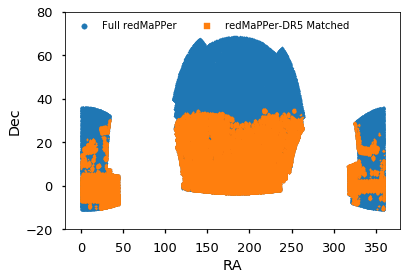

In [14]:
fig, ax = plt.subplots()
ax.scatter(rmall['RA'], rmall['DEC'], s=1, label='Full redMaPPer')
ax.scatter(rm['RA'], rm['DEC'], s=1, marker='s', label='redMaPPer-DR5 Matched')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_ylim(-20, 80)
lgnd = ax.legend(loc='upper left', frameon=False, fontsize=10, ncol=2)
for ll in lgnd.legendHandles:
    ll._sizes = [30]

In [15]:
band = ['G', 'R', 'Z']
targdepth = [24.7, 23.9, 23.0] # target 5-sigma depth
meddepth = np.zeros((3))

g: median depth = 24.147, target depth = 24.700
r: median depth = 23.675, target depth = 23.900
z: median depth = 22.833, target depth = 23.000


(21, 26)

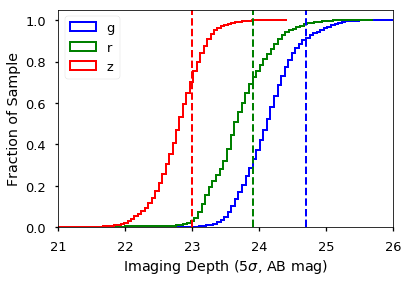

In [16]:
color = ('blue', 'green', 'red')
fig, ax = plt.subplots()
for ii, (tt, bb, col) in enumerate( zip( targdepth, band, color ) ):
    depth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(ls['GALDEPTH_{}'.format(bb)]) )
    meddepth[ii] = np.percentile(depth, [50])
    nn, bins, patches = ax.hist(depth, bins=100, histtype='step', cumulative=True,
                                label=bb.lower(), normed=True, color=col, lw=2)
    patches[0].set_xy(patches[0].get_xy()[:-1]) # delete the last point
    print('{}: median depth = {:.3f}, target depth = {:.3f}'.format(bb.lower(), meddepth[ii], tt))
    ax.axvline(x=tt, ls='--', color=col, lw=2, alpha=1.0)
    #ax.axvline(x=meddepth[ii], ls='-', color=col, lw=1, alpha=0.9)
ax.legend(loc='upper left')
ax.set_xlabel('Imaging Depth (5$\sigma$, AB mag)')
ax.set_ylabel('Fraction of Sample')
ax.set_xlim(21, 26)

In [17]:
depthcut = np.ones(len(ls)).astype(bool)
for ii, bb in enumerate(['G', 'R', 'Z']):
    depth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(ls['GALDEPTH_{}'.format(bb)]) )
    depthcut *= depth > meddepth[ii]
print('{} objects pass the median depth cuts in all three bands.'.format(np.sum(depthcut)))

53441 objects pass the median depth cuts in all three bands.


In [18]:
rmphotdeep = rmphot[depthcut]
rmdeep = rm[depthcut]
lsdeep = ls[depthcut]

#### Write out the parent sample as a multi-extension FITS file.

In [19]:
hx = fits.HDUList()
for outcat, extname in zip( (rmphotdeep, rmdeep, lsdeep), ('SDSSPHOT', 'REDMAPPER', 'LSPHOT') ):
    hdu = fits.table_to_hdu(outcat)
    hdu.header['EXTNAME'] = extname
    hx.append(hdu)
print('Writing {}'.format(parentfile))
hx.writeto(parentfile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent.fits


### QAplots

In [20]:
def _normhist(xx, ax, label=None, alpha=1.0, lw=2, bins=100):
    _, _, _ = ax.hist(xx, weights=np.ones_like(xx) / float(len(xx)), 
                      bins=bins, histtype='step', label=label,
                      lw=lw, alpha=alpha)

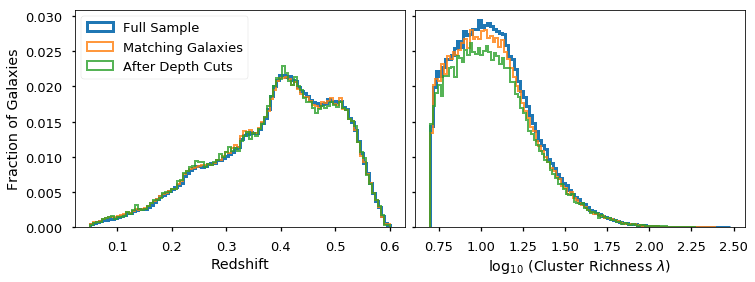

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

_normhist(rmall['Z'], ax1, label='Full Sample', lw=3)
_normhist(rm['Z'], ax1, label='Matching Galaxies', alpha=0.8)
_normhist(rmdeep['Z'], ax1, label='After Depth Cuts', alpha=0.8)
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Fraction of Galaxies')
ax1.legend(loc='upper left')

_normhist(np.log10(rmall['LAMBDA_CHISQ']), ax2, lw=3)
_normhist(np.log10(rm['LAMBDA_CHISQ']), ax2, alpha=0.8)
_normhist(np.log10(rmdeep['LAMBDA_CHISQ']), ax2, alpha=0.8)
ax2.set_xlabel('$\log_{10}$ (Cluster Richness $\lambda$)')
#ax2.set_ylabel('Fraction of Galaxies')
fig.subplots_adjust(wspace=0.03)

### Match to the UPenn-PhotDec catalogs.

Measurements were performed in SDSS g, r, and i.  Here we read all three catalogs but below we keep just the g- and r-band measurements.

In [22]:
def photdec_select(finalflag, bit):
    """Select subsets of the catalog using the finalflag bitmask.

     1 - good bulge-only galaxy
     4 - good disk-only galaxy
    10 - good two-component fit (logical_or of flags 11, 12, and 13)
    20 - bad total magnitude and size

    """
    return finalflag & np.power(2, bit) != 0

In [23]:
def select_goodmodels(modelcat, onecomp=False, twocomp=False):
    """Select various galaxies with good model fits.
    
    Args:
      modelcat: 'UPenn_PhotDec_Models_[g,r,i]band.fits' catalog.
      onecomp (bool): galaxies fitted with single-Sersic model.
      twocomp (bool): galaxies fitted with Sersic-exponential model.
    
    Notes:
      * Flag 10 is a logical_or of 11, 12, 13.
      * Flag 1, 4, and 10 are mutually exclusive.
      * If Flag 1 or 4 are set then n_disk,r_disk are -999.
    
    """
    finalflag = modelcat['finalflag']
    smalln = modelcat['n_bulge'] < 8
    goodr = modelcat['r_bulge'] > 0 # Moustakas hack

    two = photdec_select(finalflag, 10)
    two = np.logical_and( two, smalln )
    two = np.logical_and( two, goodr )
    if twocomp:
        return two

    one = np.logical_or( photdec_select(finalflag, 1), photdec_select(finalflag, 4) )
    one = np.logical_and( one, smalln )
    if onecomp:
        return one

    both = np.logical_or( one, two )
    
    return both

In [24]:
def _get_goodmodels_indices(basicdir, verbose=False):
    """Get the indices of galaxies with good model fits in all 
    three bands.
    
    """
    good = None
    for thisband in ('gband', 'rband', 'iband'):
        measurefile = os.path.join(basicdir, 'UPenn_PhotDec_nonParam_{}.fits'.format(thisband))
        modelsfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))

        measureinfo = fitsio.FITS(measurefile)
        modelsinfo = fitsio.FITS(modelsfile)    
    
        _models = Table(modelsinfo[1].read(columns=['finalflag', 'n_bulge', 'r_bulge']))
        _good = select_goodmodels(_models)
        if good is None:
            good = _good
            if verbose:
                print(measureinfo[1])
                print(modelsinfo[1])
            else:
                good = np.logical_and(good, _good)
                
    goodindx = np.where(good)[0]
    if verbose:
        print('Selected {}/{} galaxies with good model fits in gri.'.format(len(goodindx), len(_models)))
        
    return goodindx

In [25]:
def read_mendel(adddir, indx=None, verbose=False):
    """Read the UPenn-PhotDec stellar mass catalog based on the M/L ratios published
    by Mendel et al. 2014 (who used the Chabrier IMF).
    
    Note that papers by the UPenn group tend to prefer the dust-free M/L values 
    from Mendel et al. (their Table 5 instead of their Table 3); see Bernardi et al. 
    2017 for details and use 'Mstar_Tab5_Pymorph'.
    
    """
    mendelfile = os.path.join(adddir, 'UPenn_PhotDec_Mstar_mlMendel14.dat')
    columns = ('GalCount', 'FlagSerExp', 
               'Mstar_Tab5_Pymorph', 'Mstar_Tab5_Truncated', 
               'Mstar_Tab3_Pymorph', 'Mstar_Tab3_Truncated', 
               'Mstar_Tab5_Mendel', 'Mstar_Tab3_Mendel', 
               'Mstar_Tab5_cModel', 'Mstar_Tab3_cModel')
    columns = [cc.upper() for cc in columns]
    mendel = Table.read(mendelfile, format='ascii.no_header', names=columns)
    if indx is not None:
        mendel = mendel[indx]
    if verbose:
        mendel
        
    return mendel

In [26]:
def read_upenn_photdec(version='v2', verbose=False):
    """Read all the UPenn-PhotDec catalogs of interest (in all three bands), 
    restricted to just the subset of galaxies with "good" model fits.
    
    """
    photdecdir = os.path.join(os.getenv('IM_DATA_DIR'), 'upenn-photdec')
    basicdir = os.path.join(photdecdir, 'basic-catalog', version)
    adddir = os.path.join(photdecdir, 'additional-catalogs')
    
    # First get the indices of galaxies with good model fits in gri.
    goodindx = _get_goodmodels_indices(basicdir, verbose=verbose)
    
    # Now read all the basic catalogs of interest.
    models, measure = [], []
    for thisband in ('gband', 'rband', 'iband'):
        modelsfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))
        measurefile = os.path.join(basicdir, 'UPenn_PhotDec_NonParam_{}.fits'.format(thisband))
        
        models.append(Table(fitsio.read(modelsfile, ext=1, rows=goodindx, upper=True)))
        measure.append(Table(fitsio.read(measurefile, ext=1, rows=goodindx, upper=True)))

    gmodels, rmodels, imodels = models
    gmeasure, rmeasure, imeasure = measure
    del models, measure
    
    # Read the CAST and CASTmodels catalogs.
    castfile = os.path.join(basicdir, 'UPenn_PhotDec_CAST.fits')
    castinfo = fitsio.FITS(castfile)
    if verbose:
        print(castinfo[1])
    cast = Table(castinfo[1].read(rows=goodindx, upper=True))
    
    castmodelsfile = os.path.join(adddir, 'UPenn_PhotDec_CASTmodels.fits')
    castmodelsinfo = fitsio.FITS(castmodelsfile)
    castmodels = Table(castmodelsinfo[1].read(rows=goodindx, upper=True))
    if verbose:
        print(castmodelsinfo[1])

    # Finally, read the Mendel-based stellar masses.
    mendel = read_mendel(adddir, indx=goodindx, verbose=verbose)
        
    return gmodels, rmodels, imodels, gmeasure, rmeasure, imeasure, cast, castmodels, mendel

In [27]:
(gmodels, rmodels, imodels, gmeasure, rmeasure, imeasure, \
 cast, castmodels, mendel) = read_upenn_photdec(verbose=False)

In [28]:
assert(len(gmodels) == len(rmodels))
assert(len(gmodels) == len(imodels))
assert(len(gmodels) == len(gmeasure))
assert(len(gmodels) == len(rmeasure))
assert(len(gmodels) == len(imeasure))
assert(len(gmodels) == len(cast))
assert(len(gmodels) == len(castmodels))
assert(len(gmodels) == len(mendel))

In [29]:
cast[:2]

GALCOUNT,OBJID,SDSSIAU,BADFLAG,NCHILD,MODE,RUN,RERUN,CAMCOL,FIELD,OBJ,STRIPE,STARTMU,SPECOBJID,PLATE,MJD,FIBERID,RA,DEC,Z,VELDISP,VELDISPERR,ECLASS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN
int32,int64,bytes24,int32,int16,int16,int16,int16,int16,int16,int16,int32,int32,int64,int16,int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32
1,587722952230174996,SDSS J154459.28-002830.9,64,0,1,745,40,2,518,276,10,849998,96486454284255232,342,51691,261,236.247,-0.475264,0.0302843,-9999.0,-9999.0,0.15935,0.165,0.739,0,0,1
3,587722952230175138,SDSS J154522.08-002801.2,64,0,1,745,40,2,518,418,10,849998,96486454296838144,342,51691,264,236.342,-0.467023,0.160228,-9999.0,-9999.0,-0.120854,0.211,0.763,0,0,1


In [30]:
castmodels[:2]

PETROR90,PETROR50,PETROMAG,PETROMAGERR,MODELMAGERR,MODELMAG,DEVRAD,DEVAB,DEVMAG,DEVPHI,EXPRAD,EXPAB,EXPMAG,EXPPHI,FRACDEV,EXTINCTION,AA,KK,AIRMASS,GAIN,DARKVARIANCE,SKY,SKYERR,PSFWIDTH,ROWC,COLC
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
5.4904,1.96333,18.2742,0.0182216,0.00917327,18.2882,4.13141,0.303647,18.0323,4.50039,2.4008,0.345933,18.3296,5.06697,0.421262,0.361804,-24.5856,0.283262,1.19602,3.855,1.44,22.0223,0.00158274,1.42072,323.102,1517.15
8.42594,4.2561,17.9405,0.0205758,0.0105997,18.0246,16.3127,0.538468,17.2464,98.0494,5.65167,0.568125,17.8469,98.6045,0.0,0.372203,-24.5856,0.283262,1.19602,3.855,1.44,22.0223,0.00158274,1.42072,1187.86,1591.8


In [31]:
gmodels[:2]

M_TOT,M_APER,BT,R_TOT,BA_TOT,BT_APER,XCTR_BULGE,XCTR_BULGE_ERR,YCTR_BULGE,YCTR_BULGE_ERR,M_BULGE,M_BULGE_ERR,R_BULGE,R_BULGE_ERR,N_BULGE,N_BULGE_ERR,BA_BULGE,BA_BULGE_ERR,PA_BULGE,PA_BULGE_ERR,XCTR_DISK,XCTR_DISK_ERR,YCTR_DISK,YCTR_DISK_ERR,M_DISK,M_DISK_ERR,R_DISK,R_DISK_ERR,N_DISK,N_DISK_ERR,BA_DISK,BA_DISK_ERR,PA_DISK,PA_DISK_ERR,GALSKY,GALSKY_ERR,CHI2NU,FINALFLAG,AUTOFLAG,PYFLAG,PYFITFLAG
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32
18.2579,-999.0,0.322289,1.61317,0.325062,-999.0,108.23,0.07,108.58,0.04,19.4873,0.0821,1.28922,0.0274428,0.3715,0.0734,0.3736,0.0146,-83.6137,1.3108,108.65,0.19,108.51,0.07,18.6803,0.0253,4.20017,0.213036,1.0,-999.0,0.3231,0.0059,-85.2288,0.5812,22.0323,0.000360231,1.0138,5121,2112,62,2
17.8901,-999.0,1.0,4.25106,0.579431,-999.0,198.23,0.08,198.47,0.12,17.8901,0.0128,5.59714,0.101772,0.8707,0.0255,0.5794,0.0067,7.147,0.9957,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-395.604,-395.604,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,22.0315,0.000179981,1.02375,81,2056,42,0


In [32]:
gmeasure[:2]

SEXMAG,SEXMAG_ERR,SEXHRAD,SEXSKY,NUM_TARGETS,NUM_NEIGHBORFIT,APERRAD,C,C_ERR,A,A_ERR,S,S_ERR,G,M20,EXTINCTION,DISMOD,KPC_PER_ARCSEC,VMAX,SN,KCORR
float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
18.2491,0.0369,2.07306,22.0332,1,0,-999.0,2.508,0.678715,0.0463758,0.6385,0.209815,2.4432,0.489271,-1.7776,0.361804,35.6145,0.606135,2.80096e+06,-999.0,0.022755
17.7623,0.0319,4.90565,22.0288,1,0,-999.0,2.51799,0.877961,0.201678,1.2919,0.614721,6.4894,0.452863,-1.8113,0.372203,39.423,2.76111,6.99989e+08,-999.0,0.36536


In [33]:
mendel[:2]

GALCOUNT,FLAGSEREXP,MSTAR_TAB5_PYMORPH,MSTAR_TAB5_TRUNCATED,MSTAR_TAB3_PYMORPH,MSTAR_TAB3_TRUNCATED,MSTAR_TAB5_MENDEL,MSTAR_TAB3_MENDEL,MSTAR_TAB5_CMODEL,MSTAR_TAB3_CMODEL
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
1,0,9.137,9.137,9.037,9.037,9.145,9.045,9.151,9.051
3,0,11.035,11.028,11.137,11.13,11.058,11.16,11.017,11.119


#### Look at the distribution of separations to determine the matching threshold.

In [34]:
parentcoord = SkyCoord(ra=rmphotdeep['RA']*u.deg, dec=rmphotdeep['DEC']*u.deg)
upenncoord = SkyCoord(ra=cast['RA']*u.deg, dec=cast['DEC']*u.deg)
_, sep2d, _ = upenncoord.match_to_catalog_sky(parentcoord)

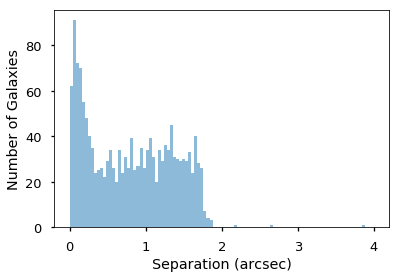

In [35]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(sep2d.arcsec, bins=100, range=(0, 4), alpha=0.5)
ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel('Number of Galaxies')

In [36]:
rad = 2.0 * u.arcsec
indx_parent, indx_upenn, d2d, _ = upenncoord.search_around_sky(parentcoord, rad)
nmatch = len(indx_parent)
print('Found {}/{} objects with matching UPenn-Photdec photometry within {}'.format(nmatch, len(rmdeep), rad))

Found 1562/53441 objects with matching UPenn-Photdec photometry within 2.0 arcsec


#### Assume that the redMaPPer redshift is correct.

But we should keep these differences in mind as we compare the stellar masses.

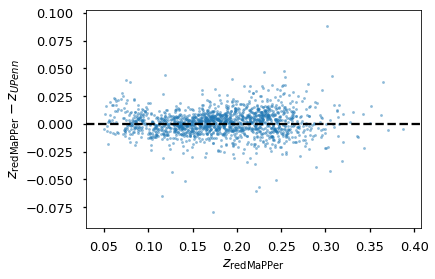

In [37]:
fig, ax = plt.subplots()
ax.scatter(rmdeep['Z'][indx_parent], rmdeep['Z'][indx_parent] - cast['Z'][indx_upenn],
           s=5, alpha=0.5)
ax.set_xlabel(r'$z_{\rm redMaPPer}$')
ax.set_ylabel(r'$z_{\rm redMaPPer} - z_{UPenn}$')
ax.axhline(y=0.0, ls='--', color='k')

#### Merge the UPenn-PhotDec catalogs (just the g-band and r-band) with the Mendel stellar mass catalog.

In [38]:
# gmodels, rmodels, imodels, gmeasure, rmeasure, imeasure, cast, castmodels, mendel
oldupenn = (gmodels[indx_upenn], rmodels[indx_upenn])
outupenn = []
outupenn.append(mendel[indx_upenn])
for models, band in zip( oldupenn, ('G', 'R') ):
    oldcols = models.dtype.names
    for oldcol in oldcols:
        newcol = '{}_{}'.format(band, oldcol)
        models.rename_column(oldcol, newcol)
    outupenn.append(models)
outupenn = hstack( outupenn )
outupenn

GALCOUNT,FLAGSEREXP,MSTAR_TAB5_PYMORPH,MSTAR_TAB5_TRUNCATED,MSTAR_TAB3_PYMORPH,MSTAR_TAB3_TRUNCATED,MSTAR_TAB5_MENDEL,MSTAR_TAB3_MENDEL,MSTAR_TAB5_CMODEL,MSTAR_TAB3_CMODEL,G_M_TOT,G_M_APER,G_BT,G_R_TOT,G_BA_TOT,G_BT_APER,G_XCTR_BULGE,G_XCTR_BULGE_ERR,G_YCTR_BULGE,G_YCTR_BULGE_ERR,G_M_BULGE,G_M_BULGE_ERR,G_R_BULGE,G_R_BULGE_ERR,G_N_BULGE,G_N_BULGE_ERR,G_BA_BULGE,G_BA_BULGE_ERR,G_PA_BULGE,G_PA_BULGE_ERR,G_XCTR_DISK,G_XCTR_DISK_ERR,G_YCTR_DISK,G_YCTR_DISK_ERR,G_M_DISK,G_M_DISK_ERR,G_R_DISK,G_R_DISK_ERR,G_N_DISK,G_N_DISK_ERR,G_BA_DISK,G_BA_DISK_ERR,G_PA_DISK,G_PA_DISK_ERR,G_GALSKY,G_GALSKY_ERR,G_CHI2NU,G_FINALFLAG,G_AUTOFLAG,G_PYFLAG,G_PYFITFLAG,R_M_TOT,R_M_APER,R_BT,R_R_TOT,R_BA_TOT,R_BT_APER,R_XCTR_BULGE,R_XCTR_BULGE_ERR,R_YCTR_BULGE,R_YCTR_BULGE_ERR,R_M_BULGE,R_M_BULGE_ERR,R_R_BULGE,R_R_BULGE_ERR,R_N_BULGE,R_N_BULGE_ERR,R_BA_BULGE,R_BA_BULGE_ERR,R_PA_BULGE,R_PA_BULGE_ERR,R_XCTR_DISK,R_XCTR_DISK_ERR,R_YCTR_DISK,R_YCTR_DISK_ERR,R_M_DISK,R_M_DISK_ERR,R_R_DISK,R_R_DISK_ERR,R_N_DISK,R_N_DISK_ERR,R_BA_DISK,R_BA_DISK_ERR,R_PA_DISK,R_PA_DISK_ERR,R_GALSKY,R_GALSKY_ERR,R_CHI2NU,R_FINALFLAG,R_AUTOFLAG,R_PYFLAG,R_PYFITFLAG
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32
56990,0,11.912,11.881,11.905,11.874,11.981,11.974,11.79,11.783,17.7828,-999.0,1.0,9.99037,0.805744,-999.0,167.4,0.08,167.77,0.09,17.7828,0.1237,11.1243,2.19265,4.5268,0.412,0.8057,0.0316,9.0479,5.067,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-395.604,-395.604,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,21.538,0.000190047,1.00448,7,8,298,2,16.3522,17.55,1.0,10.2952,0.896712,1.0,167.75,0.03,167.59,0.03,16.3522,0.0617,10.8684,1.17893,5.3699,0.2567,0.8966,0.0156,-14.8434,5.0653,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20.6934,0.000107467,0.9687,7,8,298,2
278215,0,11.425,11.401,11.3,11.276,11.424,11.299,11.212,11.087,15.9909,-999.0,1.0,5.46524,0.718929,-999.0,158.7,0.01,100.68,0.01,15.9909,0.0141,6.49963,0.179546,5.1724,0.0829,0.7069,0.0042,-34.4382,0.5332,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-395.604,-395.604,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,21.9633,0.000256959,1.08302,7,8,42,0,15.0286,15.0286,1.0,5.50357,0.7053,1.0,158.04,0.01,111.32,0.01,15.0286,0.0097,6.58797,0.125849,5.3421,0.0575,0.7008,0.0029,-33.4754,0.3527,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20.9601,0.000189955,1.05845,7,8,42,0
535241,0,12.113,12.092,12.017,11.996,12.028,11.932,11.953,11.857,16.2077,-999.0,1.0,16.624,0.678367,-999.0,204.65,0.03,236.72,0.03,16.2077,0.0552,20.1762,1.94139,5.3311,0.21,0.6782,0.0103,-68.5164,1.1781,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-395.604,-395.604,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,21.8884,0.000210468,1.08616,7,8,42,0,15.1459,15.3786,1.0,13.1268,0.6645,1.0,204.7,0.02,236.98,0.01,15.1459,0.0204,16.1029,0.571547,4.9082,0.0786,0.6626,0.0043,-70.2462,0.4834,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20.9424,0.000127904,1.07908,7,8,42,0
16958,-1,12.07,12.069,12.026,12.025,11.91,11.866,11.778,11.734,18.5949,-999.0,1.0,8.34222,-999.0,-999.0,171.5,0.19,63.85,0.13,18.5949,0.1982,11.2888,3.30145,3.2803,0.5329,0.5452,0.0366,-72.847,3.4413,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-395.604,-395.604,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,21.7123,0.00027

#### Write everything out as a multi-extension FITS file.

In [39]:
hx = fits.HDUList()
for outcat, extname in zip( (rmphotdeep[indx_parent], rmdeep[indx_parent], lsdeep[indx_parent], outupenn), 
                           ('SDSSPHOT', 'REDMAPPER', 'LSPHOT', 'UPENN') ):
    hdu = fits.table_to_hdu(outcat)
    hdu.header['EXTNAME'] = extname
    hx.append(hdu)
print('Writing {}'.format(parentupennfile))
hx.writeto(parentupennfile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/legacyhalos-upenn-parent.fits


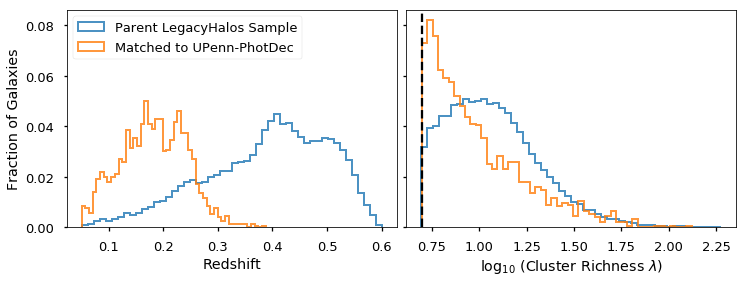

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

_normhist(rmdeep['Z'], ax1, label='Parent LegacyHalos Sample', alpha=0.8, bins=50)
_normhist(rmdeep['Z'][indx_parent], ax1, label='Matched to UPenn-PhotDec', 
          alpha=0.8, bins=50)

ax1.set_xlabel('Redshift')
ax1.set_ylabel('Fraction of Galaxies')
ax1.legend(loc='upper left')

_normhist(np.log10(rmdeep['LAMBDA_CHISQ']), ax2, alpha=0.8, bins=50)
_normhist(np.log10(rmdeep['LAMBDA_CHISQ'][indx_parent]), ax2, 
          alpha=0.8, bins=50)
ax2.set_xlabel('$\log_{10}$ (Cluster Richness $\lambda$)')
ax2.axvline(x=np.log10(5), ls='--', color='k')
fig.subplots_adjust(wspace=0.03)